Necessary imports


In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow import keras
# import keras # Keras can be imported as a separate library (and can use different backends)
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Input, Activation, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, SGD, Adagrad, Adadelta, Adam 
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import metrics
from tensorflow.keras import losses
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import trange
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt



batch_size = 128
num_classes = 10
epochs = 20

Importing and preparing the data (simple MNIST dataset)


In [2]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## flatten the data from 2D to 1D (vector)
## the data shape is [28x28]

x_train = x_train.reshape(60000, 784) 
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

## convert to float [0.0 - 1.0]
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(y_train.shape)

11501568/11490434 [==============================] - 0s 0us/step
60000 train samples
10000 test samples
(60000,)


Convert class vectors (single label) to One-hot encoding (vector encoding)

In [3]:
## One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

There are two main ways to define model architecture in Keras - Sequential and Functional APIs.

- Sequential API is very easy to understand and can be a great tool for creating linear (sequential) model architectures. 

- Functional API can be used to create more complicated architectures, with multiple inputs and outputs, as well as divergences from linear processing path.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trai

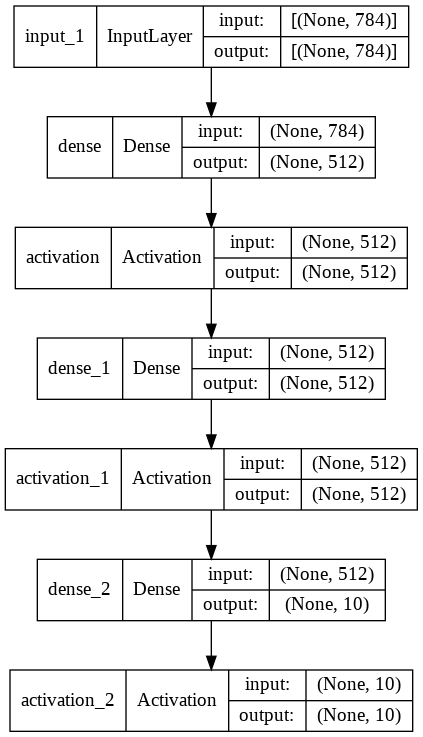

In [4]:
## Prepare model architecture using Sequential API - long version
model = Sequential()

model.add(Input(shape=(784,)))
model.add(Dense(512))
model.add(Activation('relu'))

# model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))

# model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# show model summary
model.summary()
# # visualize the model
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


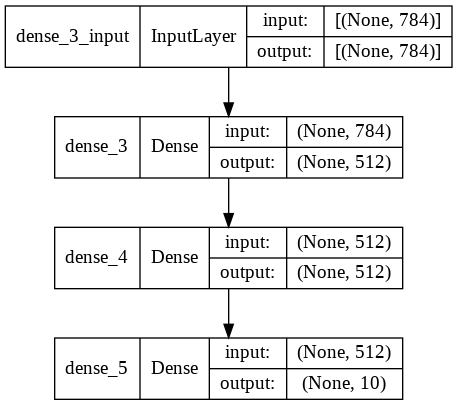

In [5]:
## Prepare model architecture using Sequential API
model = Sequential()

model.add(Dense(512, activation='relu', input_shape=(784,)))
# model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))


# show model summary
model.summary()
# # visualize the model
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
 output (Activation)         (None, 10)                0     

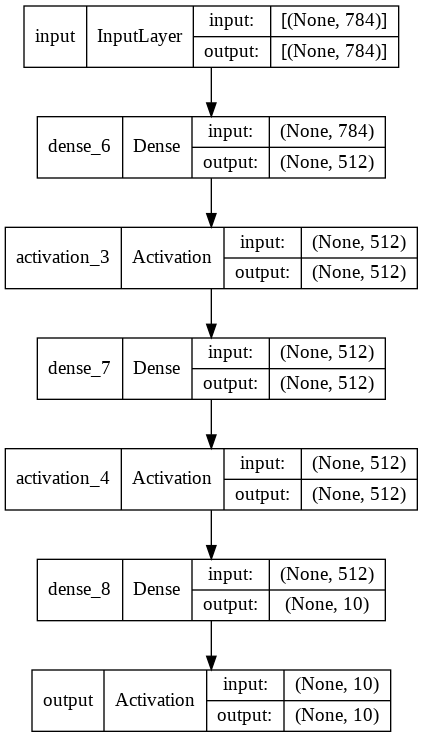

In [6]:
# Prepare model architecture using Functional API - long version

input = Input(shape=(784,), name='input')
x = Dense(512)(input)
x = Activation('relu')(x)
x = Dense(512)(x)
x = Activation('relu')(x)
x = Dense(num_classes)(x)
output = Activation('softmax', name='output')(x)

model = Model(inputs=[input], outputs=[output] )

# show model summary
model.summary()
# # visualize the model
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 first_dense (Dense)         (None, 512)               401920    
                                                                 
 second_dense (Dense)        (None, 512)               262656    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


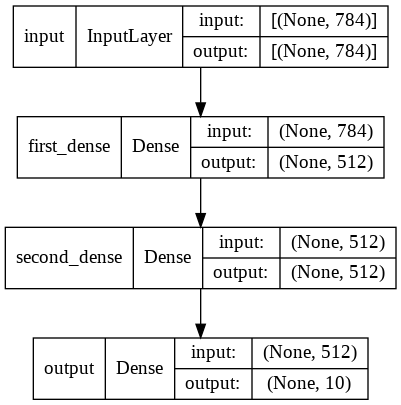

In [7]:
# Prepare model architecture using Functional API - concise

input = Input(shape=(784,), name='input')
x = Dense(512, activation='relu', name='first_dense')(input)
x = Dense(512, activation='relu', name='second_dense')(x)
output = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=[input], outputs=[output] )


# show model summary
model.summary()
# # visualize the model
dot_img_file = '/tmp/model_1.png'
plot_model(model, to_file=dot_img_file, show_shapes=True)



In order to use the model it needs to be "compiled" first in Keras. 
Compilation process prepares the model for training - sets the optimizer (backpropagation technique), loss, metrics etc.

In [8]:
# set params using text (good for built-in types)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])


In [9]:
# OR set params using objects (so we can even use custom losses, metrics or optimizers)
model.compile(loss=losses.categorical_crossentropy,
              optimizer=RMSprop(),
              metrics=[metrics.categorical_accuracy])

Choosing the correct optimizer and setting the parameters (simplest of which is Learning Rate) can increase the speed of training step and/or accuracy of the resulting model. For more information please check:

https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/

https://keras.io/optimizers/

In [10]:
# Train model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
469/469 [==============================] - 5s 6ms/step - loss: 0.2191 - categorical_accuracy: 0.9326 - val_loss: 0.1045 - val_categorical_accuracy: 0.9675
Epoch 2/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0822 - categorical_accuracy: 0.9744 - val_loss: 0.0781 - val_categorical_accuracy: 0.9751
Epoch 3/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0549 - categorical_accuracy: 0.9833 - val_loss: 0.0717 - val_categorical_accuracy: 0.9793
Epoch 4/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0384 - categorical_accuracy: 0.9881 - val_loss: 0.0778 - val_categorical_accuracy: 0.9799
Epoch 5/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0291 - categorical_accuracy: 0.9906 - val_loss: 0.1041 - val_categorical_accuracy: 0.9778
Epoch 6/20
469/469 [==============================] - 3s 6ms/step - loss: 0.0220 - categorical_accuracy: 0.9926 - val_loss: 0.0867 - val_categorical_accuracy: 0.9801
Epoc

In [11]:
# history object stores the history of training as a dictionary

# Available data:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


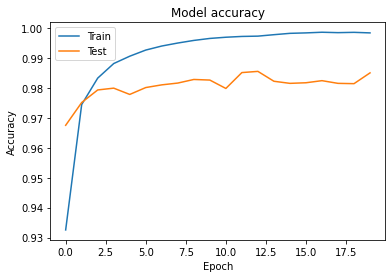

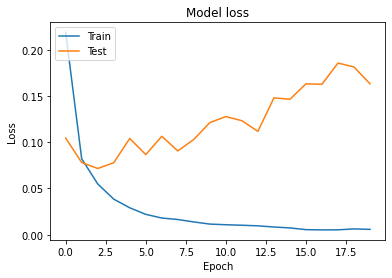

In [12]:
# visualize training history 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Models can be saved to disk, for later use (inference) or for retraining

In [13]:
modelPath = 'savedModel.h5'

model.save(modelPath)
loadedModel = load_model(modelPath)
loadedModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 first_dense (Dense)         (None, 512)               401920    
                                                                 
 second_dense (Dense)        (None, 512)               262656    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


The model object remebers it's state for the current session - which means, that it can be "refined" (fine-tuned) by simply performing more iterations

Epoch 21/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0045 - categorical_accuracy: 0.9988 - val_loss: 0.1936 - val_categorical_accuracy: 0.9807
Epoch 22/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0056 - categorical_accuracy: 0.9984 - val_loss: 0.2049 - val_categorical_accuracy: 0.9826
Epoch 23/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0056 - categorical_accuracy: 0.9987 - val_loss: 0.1857 - val_categorical_accuracy: 0.9823
Epoch 24/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0051 - categorical_accuracy: 0.9988 - val_loss: 0.2124 - val_categorical_accuracy: 0.9815
Epoch 25/25
469/469 [==============================] - 3s 6ms/step - loss: 0.0053 - categorical_accuracy: 0.9988 - val_loss: 0.1959 - val_categorical_accuracy: 0.9831
Test loss: 0.19585870206356049
Test accuracy: 0.9830999970436096


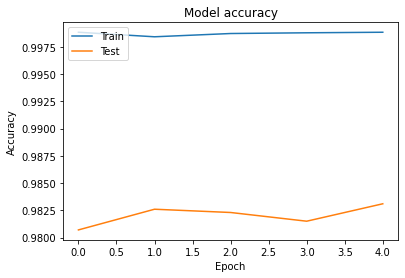

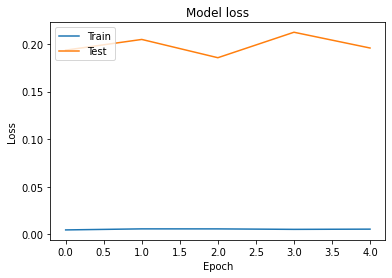

In [14]:
# Refine model
startingEpoch = epochs
epochsToAdd = 5

history = loadedModel.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=(startingEpoch + epochsToAdd), # total epochs
                    verbose=1,
                    validation_data=(x_test, y_test), 
                    initial_epoch = startingEpoch # we start counting at this epoch
                    )

score = loadedModel.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

It is also possible to save only weights of the model, or even just the architecture.

This can be very usefull to either store the model, but without the state of the optimizer or to save the architecture as a proof of concept, to then train properly on a different or extended dataset


In [15]:
# saving architecture to JSON file
json_config = model.to_json()
reinitialized_model = keras.models.model_from_json(json_config)

with open("model_architecture.json", "w") as f:
    f.write(json_config)
    
# saving just weights
model.save_weights('model_weights.h5')


# loading architecture and weights
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 first_dense (Dense)         (None, 512)               401920    
                                                                 
 second_dense (Dense)        (None, 512)               262656    
                                                                 
 output (Dense)              (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


Training can be a long process, so it might be necessary to introduce some restrictions and fail-safes.

If the training is stopped prematurely due to an error, then it is possibe to loose progress. Therefore it is always advisable to use the checkpointing system in Keras

In order to avoid overfitting it is also advisable to terminate the training task earlier than expected, based on some criteria (for example trend of chosen metric)

Both theese tasks can be achieved simultaneously using callbacks

In [16]:
# Early stopping and checkpoint system

checkpoint_path = 'checkpoint-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5'

# patience - how many epochs to wait (max) before the system decides that the 
# trend of measured metric deviated from the desired. For example if monitoring 
# the validation loss and param set to 30 epoch if during these epochs there is no
# overall downward trend, then the training will be stopped

from keras.callbacks import Callback

# https://www.tensorflow.org/guide/keras/custom_callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch} finished')

    def on_train_end(self, logs=None):
        print('Training over!')

keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=False, mode='min'),
      CustomCallback()
]

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=[metrics.categorical_accuracy] )

epochs = 100

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=keras_callbacks)




Epoch 1/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0182 - categorical_accuracy: 0.9958 - val_loss: 0.1363 - val_categorical_accuracy: 0.9810
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0164 - categorical_accuracy: 0.9960 - val_loss: 0.1294 - val_categorical_accuracy: 0.9756
Epoch 3/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0127 - categorical_accuracy: 0.9964 - val_loss: 0.1166 - val_categorical_accuracy: 0.9818
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0135 - categorical_accuracy: 0.9965 - val_loss: 0.1213 - val_categorical_accuracy: 0.9818
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.0083 - categorical_accuracy: 0.9977 - val_loss: 0.1010 - val_categorical_accuracy: 0.9826
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.0125 - categorical_accuracy: 0.9962 - val_loss: 0.1143 - val_categorical_accuracy: 0.978

In [17]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

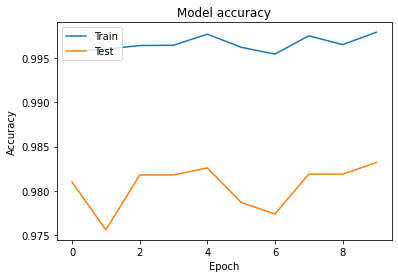

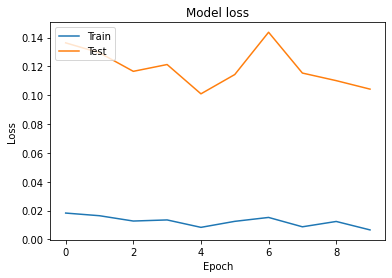

In [18]:
# visualize training history 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

TASK 1:
- Implement an MLP network using Keras framework, using the same architecture as in your previous homework (MLP from scratch). Compare the results (train time and accuracy) on your own datasets.
- Perform manual hyperparameter tuning - try to find optimal architecture for each dataset (using Keras), by tuning the number of layers, number of neurons ets. 

### Import previously created dataset (x, o, + images)

In [51]:
from google.colab import drive
drive.mount('/content/drive')

X = np.load('drive/MyDrive/lab2-dataset/X.npy')
y = np.load('drive/MyDrive/lab2-dataset/y.npy')
bb = np.load('drive/MyDrive/lab2-dataset/bb.npy')

X = (X / 255.).reshape(len(X), 32*32*3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(811, 3072)
(811,)


### Import MLP from scratch architecture

In [52]:
"""
myNetwork class parameters:
      neurons_count: int (number of neurons in layer)     
      inputs_count: int (number of inputs to each neuron of layer)
      weights: OPTIONAL - tuple of arrays (arrays of weights for each of layer)
      biases: OPTIONAL - tuple of arrays (arrays of biases for each of layer)
"""

class myLayer:
    def __init__(self, inputs_count, neuron_count, learning_rate=0.01, weights=None, biases=None):
        self.learning_rate = learning_rate

        # check if weights or biases are passed as an network argument, otherwise initialize it by default
        if weights is not None:
            self.weights = np.array(weights)  
        else:  
            self.weights = np.random.normal(scale=0.01, size=(neuron_count, inputs_count))

        if biases is not None:
            self.biases = np.array(biases)
        else:  
            self.biases = np.zeros(neuron_count)

    def forward(self, inputs):
        return np.dot(inputs, self.weights.T) + self.biases

    def backward(self, input, grad):
        grad_input = np.dot(grad, self.weights)
        grad_weights = np.dot(input.T, grad)
        grad_biases = grad.mean(axis=0) * input.shape[0]

        self.weights = self.weights - self.learning_rate * grad_weights.T
        self.biases = self.biases - self.learning_rate * grad_biases.T

        return grad_input

# ACTIVATION FUNCTIONS

class sigmoid():
    def forward(self, x):
      return 1 / (1 + np.exp(-X))
    def backward(self, x, grad):
      sig_grad = x * (1 - x)
      return grad * sig_grad

class relu():
    def forward(self, x):
      return x * (x > 0)
    def backward(self, x, grad):
      re_grad = 1 * (x > 0)
      return grad * re_grad

class tanh():
    def forward(self, x):
      return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    def backward(self, x, grad):
      tan_grad = 1 - (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))**2
      return grad * tan_grad

def softmax_crossentropy_with_logits(logits, reference_answers):
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    xentropy = -logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1, keepdims=True)
    return (- ones_for_answers + softmax) / logits.shape[0]

class myNetwork:
    def __init__(self):
        self.layers_instances = []

    def add_layer(self, layer):
        self.layers_instances.append(layer)

    def forward(self, inputs):
        self.inputs = [inputs]

        current_state = np.array(inputs)
        for layer in self.layers_instances:
          current_state = layer.forward(current_state)
          self.inputs.append(current_state)
        return current_state

    def backward(self, grad):
        current_state = grad
        for layer_index in range(len(self.layers_instances))[::-1]:
          layer = self.layers_instances[layer_index]
          current_state = layer.backward(self.inputs[layer_index], current_state)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)

    if shuffle:
        indices = np.random.permutation(len(inputs)) 

    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize, desc='minibatch iteration'):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)

        yield inputs[excerpt], targets[excerpt]

### Training MLP from scratch on x, o, + images dataset

In [53]:
MLP_scratch = myNetwork()
MLP_scratch.add_layer(myLayer(32*32*3, 128))
MLP_scratch.add_layer(relu())
MLP_scratch.add_layer(myLayer(128, 32))
MLP_scratch.add_layer(relu())
MLP_scratch.add_layer(myLayer(32, 3))

test_accuracy = []
for epoch in range(20):
    epoch_loss = []
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=1, shuffle=True):

        ### forward ###
        logits = MLP_scratch.forward(x_batch)

        ### loss calculation ###
        loss = softmax_crossentropy_with_logits(logits, y_batch)
        epoch_loss.append(np.mean(loss))

        ### backward ###
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y_batch)
        MLP_scratch.backward(loss_grad)

    preds = []
    for x_batch, _ in iterate_minibatches(X_test, y_test, batchsize=1, shuffle=False):
        preds.append(np.argmax(MLP_scratch.forward(x_batch)))
    test_accuracy.append(accuracy_score(y_test, preds))
    print(f'\nEpoch: {epoch + 1} \t Loss: {np.mean(epoch_loss)} \t Test accuracy: {accuracy_score(y_test, preds)} \n')

minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 5150.90it/s]



Epoch: 1 	 Loss: 1.099955511051251 	 Test accuracy: 0.43956043956043955 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4314.15it/s]



Epoch: 2 	 Loss: 1.100469149093566 	 Test accuracy: 0.43956043956043955 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 3792.85it/s]



Epoch: 3 	 Loss: 1.0992494285354737 	 Test accuracy: 0.3076923076923077 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 5034.32it/s]



Epoch: 4 	 Loss: 1.0959086286716653 	 Test accuracy: 0.37362637362637363 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 5062.56it/s]



Epoch: 5 	 Loss: 1.0898231888651215 	 Test accuracy: 0.43956043956043955 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 5016.98it/s]



Epoch: 6 	 Loss: 1.0613309890363418 	 Test accuracy: 0.3076923076923077 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4144.39it/s]



Epoch: 7 	 Loss: 0.9937016229255045 	 Test accuracy: 0.25274725274725274 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4273.29it/s]



Epoch: 8 	 Loss: 0.8655082645053205 	 Test accuracy: 0.5934065934065934 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4031.15it/s]



Epoch: 9 	 Loss: 0.6448015421019274 	 Test accuracy: 0.7582417582417582 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4918.13it/s]



Epoch: 10 	 Loss: 0.49289873838387477 	 Test accuracy: 0.6703296703296703 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4819.58it/s]



Epoch: 11 	 Loss: 0.39264487051575964 	 Test accuracy: 0.8681318681318682 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4527.18it/s]



Epoch: 12 	 Loss: 0.3055623935659341 	 Test accuracy: 0.8351648351648352 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4405.12it/s]



Epoch: 13 	 Loss: 0.2175536984846232 	 Test accuracy: 0.7472527472527473 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4792.83it/s]



Epoch: 14 	 Loss: 0.1847308562854366 	 Test accuracy: 0.6923076923076923 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4155.40it/s]



Epoch: 15 	 Loss: 0.12392661129925069 	 Test accuracy: 0.9010989010989011 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4179.65it/s]



Epoch: 16 	 Loss: 0.20249123933347898 	 Test accuracy: 0.9120879120879121 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 5212.38it/s]



Epoch: 17 	 Loss: 0.11931044581204643 	 Test accuracy: 0.7472527472527473 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4192.97it/s]



Epoch: 18 	 Loss: 0.11423361600160534 	 Test accuracy: 0.967032967032967 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 3866.93it/s]



Epoch: 19 	 Loss: 0.09415975767262239 	 Test accuracy: 0.8461538461538461 



minibatch iteration: 100%|██████████| 91/91 [00:00<00:00, 4911.81it/s]


Epoch: 20 	 Loss: 0.03357638623385325 	 Test accuracy: 0.945054945054945 



### Training MLP created using Keras on x, o, + images dataset

In [54]:
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

MLP_keras = Sequential()

MLP_keras.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
MLP_keras.add(Dense(32, activation='relu'))
MLP_keras.add(Dense(3, activation='softmax'))


MLP_keras.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = MLP_keras.fit(X_train, y_train,
                    batch_size=1,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

score = MLP_keras.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
811/811 [==============================] - 3s 4ms/step - loss: 1.1880 - accuracy: 0.3231 - val_loss: 1.0738 - val_accuracy: 0.3736
Epoch 2/20
811/811 [==============================] - 3s 4ms/step - loss: 1.0438 - accuracy: 0.4291 - val_loss: 1.1116 - val_accuracy: 0.4066
Epoch 3/20
811/811 [==============================] - 3s 3ms/step - loss: 0.9334 - accuracy: 0.5413 - val_loss: 0.9506 - val_accuracy: 0.5165
Epoch 4/20
811/811 [==============================] - 3s 4ms/step - loss: 0.7685 - accuracy: 0.6400 - val_loss: 0.8672 - val_accuracy: 0.5495
Epoch 5/20
811/811 [==============================] - 3s 4ms/step - loss: 0.5151 - accuracy: 0.7818 - val_loss: 0.6463 - val_accuracy: 0.6703
Epoch 6/20
811/811 [==============================] - 3s 4ms/step - loss: 0.3798 - accuracy: 0.8557 - val_loss: 0.4685 - val_accuracy: 0.7802
Epoch 7/20
811/811 [==============================] - 3s 4ms/step - loss: 0.2237 - accuracy: 0.9186 - val_loss: 0.3392 - val_accuracy: 0.8571
Epoch 

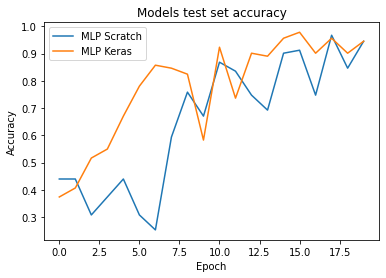

In [55]:
plt.plot(test_accuracy)
plt.plot(history.history['val_accuracy'])
plt.title('Models test set accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['MLP Scratch', 'MLP Keras'], loc='upper left')
plt.show()

As we can see from chart above, when traning on x, +, o images dataset, both MLP models performed similary. Both models scored above 90% accuracy on test set, with about 1 min traning time (about 3 sec on each epoch). Models were created using 3 dense layers with 128, 32, 3 neurons.

### Manual hyper-parameter tuning

In [24]:
MLP_keras_tuning = Sequential()

MLP_keras_tuning.add(Dense(32, activation='sigmoid', input_shape=(32*32*3,)))
MLP_keras_tuning.add(Dense(8, activation='sigmoid'))
MLP_keras_tuning.add(Dense(3, activation='softmax'))


MLP_keras_tuning.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

history = MLP_keras_tuning.fit(X_train, y_train,
                    batch_size=2,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

score = MLP_keras_tuning.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
406/406 [==============================] - 2s 5ms/step - loss: 1.1112 - accuracy: 0.3711 - val_loss: 1.0660 - val_accuracy: 0.4176
Epoch 2/20
406/406 [==============================] - 2s 4ms/step - loss: 1.0431 - accuracy: 0.4390 - val_loss: 1.0437 - val_accuracy: 0.4396
Epoch 3/20
406/406 [==============================] - 2s 4ms/step - loss: 0.9743 - accuracy: 0.5339 - val_loss: 0.9888 - val_accuracy: 0.4945
Epoch 4/20
406/406 [==============================] - 2s 4ms/step - loss: 0.8677 - accuracy: 0.5968 - val_loss: 1.0736 - val_accuracy: 0.4066
Epoch 5/20
406/406 [==============================] - 2s 4ms/step - loss: 0.7902 - accuracy: 0.6782 - val_loss: 0.8596 - val_accuracy: 0.6374
Epoch 6/20
406/406 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.7497 - val_loss: 0.8054 - val_accuracy: 0.5934
Epoch 7/20
406/406 [==============================] - 2s 4ms/step - loss: 0.5758 - accuracy: 0.8163 - val_loss: 0.7287 - val_accuracy: 0.6813
Epoch 

After trying some manual hyperparameters tuning, I was enable to achive better accuracy score than the one these 95% from two cells above. I've tried to use different number of neurons (in input and hidden layers), different optimizers (SGD, adam, RMSprop) and different batch sizes (x, o, + dataset is quite small, so definetely batch_size should be small).

### Convolutional Neural Networks

Creating simple Conv networks in Keras is very similiar to MLP. The main difference is the dimmensionality of input and internal tensors

In [56]:
# reload the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

## the data shape is [28x28] - we are changing it to a [28x28x1]

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')




## convert to float [0.0 - 1.0]
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(x_train.shape)

## One-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples
(60000, 28, 28, 1)


In [26]:
# Convolutional network using Conv2D layer and Sequential API (long version)

model = tf.keras.Sequential()

model.add(Conv2D(64, (3,3), input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten()) # we need to resize the data to be able to use Dense layers
model.add(Dense(64))
model.add(Dense(10))
model.add(Activation('softmax'))


model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
              metrics=['categorical_accuracy']) # we can mix text and object based parameters in one compile


model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 activation_5 (Activation)   (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 activation_6 (Activation)   (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                  

In [27]:
# training and showing history
epochs = 10


# Train model
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])



Epoch 1/10
469/469 [==============================] - 14s 13ms/step - loss: 0.1928 - categorical_accuracy: 0.9438 - val_loss: 0.0591 - val_categorical_accuracy: 0.9822
Epoch 2/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0536 - categorical_accuracy: 0.9839 - val_loss: 0.0457 - val_categorical_accuracy: 0.9846
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0388 - categorical_accuracy: 0.9886 - val_loss: 0.0437 - val_categorical_accuracy: 0.9851
Epoch 4/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0306 - categorical_accuracy: 0.9902 - val_loss: 0.0301 - val_categorical_accuracy: 0.9913
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0249 - categorical_accuracy: 0.9922 - val_loss: 0.0293 - val_categorical_accuracy: 0.9914
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0221 - categorical_accuracy: 0.9928 - val_loss: 0.0373 - val_categorical_accuracy: 0.98

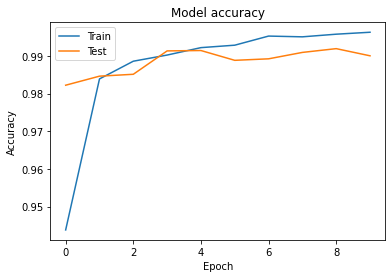

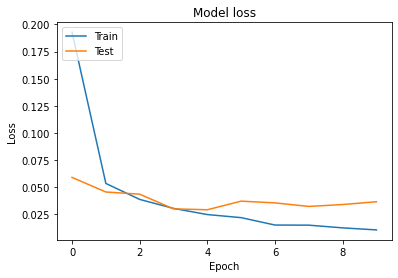

In [28]:
# visualize training history 
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Very often, in case of image classification, the main problem is the lack of properly classified training data. However, it is possible to generate additional (artificial) samples using generators

Fake samples will never be as good as real ones (Ground Truth), but in many situations can help (for example, when objects on images are symmetrical simply flipping the images will generate twice the amount of valid samples)

In [34]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
import os


# set-up 
batch_size = 32
num_classes = 10
epochs = 10

# Use data augmentation? Default to false 
data_augmentation = True

save_dir = 'saved_models'
model_name = 'keras_cifar10_model.h5'


In [38]:
# CIFAR10 dataset (color images), split between train and test sets:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [39]:
# create a more advanced architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


# initiate RMSprop optimizer
opt = RMSprop(learning_rate=0.0001, decay=1e-6)

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy'])



In [40]:
if data_augmentation:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    
    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
else:
  print('Not using data augmentation')





Using real-time data augmentation.


In [41]:
# Train the model

if data_augmentation:
  # Fit the model on the batches generated by datagen.flow().
  model.fit(datagen.flow(x_train, y_train,
                                    batch_size=batch_size),
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      workers=4)

else:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)


Epoch 1/10
1563/1563 [==============================] - 60s 38ms/step - loss: 1.8610 - categorical_accuracy: 0.3146 - val_loss: 1.5874 - val_categorical_accuracy: 0.4252
Epoch 2/10
1563/1563 [==============================] - 58s 37ms/step - loss: 1.5975 - categorical_accuracy: 0.4148 - val_loss: 1.3946 - val_categorical_accuracy: 0.4919
Epoch 3/10
1563/1563 [==============================] - 59s 37ms/step - loss: 1.4793 - categorical_accuracy: 0.4634 - val_loss: 1.3199 - val_categorical_accuracy: 0.5290
Epoch 4/10
1563/1563 [==============================] - 59s 38ms/step - loss: 1.3944 - categorical_accuracy: 0.4950 - val_loss: 1.2350 - val_categorical_accuracy: 0.5524
Epoch 5/10
1563/1563 [==============================] - 59s 37ms/step - loss: 1.3248 - categorical_accuracy: 0.5266 - val_loss: 1.1858 - val_categorical_accuracy: 0.5743
Epoch 6/10
1563/1563 [==============================] - 59s 38ms/step - loss: 1.2631 - categorical_accuracy: 0.5511 - val_loss: 1.1330 - val_categoric

In [ ]:
# Score trained model.

scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [ ]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Task 2
- Implement a convolutional network for each of your own datasets. Compare the results to your best architecture based on Dense layers (MLP) and Convolutional layers (CNN)
- Integrate generators and callbacks in your training. Investigate the impact of using a generator on accuracy and speed of training on your on custom datasets.

### Import previously created dataset (x, o, + images)

In [85]:
from google.colab import drive
drive.mount('/content/drive')

X = np.load('drive/MyDrive/lab2-dataset/X.npy')
y = np.load('drive/MyDrive/lab2-dataset/y.npy')
bb = np.load('drive/MyDrive/lab2-dataset/bb.npy')

X = (X / 255.)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(811, 32, 32, 3)
(811,)


### CNN network traning on x, +, o images dataset

In [89]:
#y_train = keras.utils.to_categorical(y_train, 3)
#y_test = keras.utils.to_categorical(y_test, 3)

print(y_test[0])

CNN_keras = Sequential()

CNN_keras.add(Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)))
CNN_keras.add(MaxPooling2D(pool_size=(2,2)))
CNN_keras.add(Conv2D(64, (3,3), activation='relu'))
CNN_keras.add(MaxPooling2D(pool_size=(2,2)))
CNN_keras.add(Flatten())
CNN_keras.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
CNN_keras.add(Dense(32, activation='relu'))
CNN_keras.add(Dense(3, activation='softmax'))


CNN_keras.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = CNN_keras.fit(X_train, y_train,
                    batch_size=1,
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test))

score = CNN_keras.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

[0. 1. 0.]
Epoch 1/20
811/811 [==============================] - 5s 5ms/step - loss: 1.1122 - accuracy: 0.3822 - val_loss: 1.0377 - val_accuracy: 0.5495
Epoch 2/20
811/811 [==============================] - 4s 5ms/step - loss: 0.2329 - accuracy: 0.9026 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 3/20
811/811 [==============================] - 4s 5ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 4/20
811/811 [==============================] - 4s 5ms/step - loss: 1.2974e-04 - accuracy: 1.0000 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/20
811/811 [==============================] - 4s 5ms/step - loss: 4.3023e-05 - accuracy: 1.0000 - val_loss: 6.6008e-04 - val_accuracy: 1.0000
Epoch 6/20
811/811 [==============================] - 4s 5ms/step - loss: 2.2429e-05 - accuracy: 1.0000 - val_loss: 7.3573e-04 - val_accuracy: 1.0000
Epoch 7/20
811/811 [==============================] - 4s 5ms/step - loss: 1.2889e-05 - accuracy: 1.0000 - val_loss: 8

It seems that adding convolutional layers to model which was tranining on x, +, o images dataset, increased accuacy a lot. Just after first epoch, model scores 100% accuracy. We can see how big is impact of convolutional layers, when it comes to detect simple shapes.

### Adding callbacks and generators

In [88]:
class CustomCallback_CNN(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f' Epoch {epoch} finished')

CNN_keras_callbacks = [
      EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001),
      CustomCallback_CNN()
]

CNN_keras_generator = Sequential()

CNN_keras_generator.add(Conv2D(64, (3,3), activation='relu', input_shape=(32, 32, 3)))
CNN_keras_generator.add(MaxPooling2D(pool_size=(2,2)))
CNN_keras_generator.add(Conv2D(64, (3,3), activation='relu'))
CNN_keras_generator.add(MaxPooling2D(pool_size=(2,2)))
CNN_keras_generator.add(Flatten())
CNN_keras_generator.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
CNN_keras_generator.add(Dense(32, activation='relu'))
CNN_keras_generator.add(Dense(3, activation='softmax'))


CNN_keras_generator.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = CNN_keras_generator.fit(datagen.flow(X_train, y_train,
                    batch_size=1),
                    epochs=20,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=CNN_keras_callbacks)

score = CNN_keras_generator.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
811/811 [==============================] - 6s 6ms/step - loss: 1.0973 - accuracy: 0.3379 - val_loss: 1.0871 - val_accuracy: 0.4396
Epoch 2/20
811/811 [==============================] - 5s 7ms/step - loss: 1.1046 - accuracy: 0.3514 - val_loss: 1.0901 - val_accuracy: 0.4396
Epoch 3/20
811/811 [==============================] - 5s 7ms/step - loss: 0.8615 - accuracy: 0.5253 - val_loss: 0.1910 - val_accuracy: 0.9121
Epoch 4/20
811/811 [==============================] - 5s 6ms/step - loss: 0.0923 - accuracy: 0.9716 - val_loss: 0.0264 - val_accuracy: 0.9890
Epoch 5/20
811/811 [==============================] - 5s 6ms/step - loss: 0.0285 - accuracy: 0.9975 - val_loss: 8.0920e-04 - val_accuracy: 1.0000
Epoch 6/20
811/811 [==============================] - 5s 6ms/step - loss: 0.0355 - accuracy: 0.9889 - val_loss: 5.5134e-04 - val_accuracy: 1.0000
Epoch 7/20
811/811 [==============================] - 5s 6ms/step - loss: 0.0068 - accuracy: 1.0000 - val_loss: 8.2806e-05 - val_accuracy: 1

After adding generator and callbacks to the model, we can see now after 4 epochs, model is 100% accurate on validation data. New images provided by generator makes it harder to learn, but second model propably will generalize better thanks to that generator. More samples mean also longer traning time, which now takes 5sec on each epoch, but using EarlyStopping callback, we could stop model from learning after it's not improving anymore, which means that overall learning time can be shorter.

Additional task (extra points)
- Prepare a network with two inputs and single output, that takes two images and predicts if the objects on the images are of the same or different class

# Hyperparameter tuning - automatic search using tools

In [90]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.7 MB/s 


In [91]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keras_tuner as kt

# Download and prepare the dataset - Fashion MNIST
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

4431872/4422102 [==============================] - 0s 0us/step


In [92]:
# Define the model
# The model builder function returns a compiled model and uses hyperparameters you define inline to hypertune the model

def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [93]:
# Instantiate the tuner to perform the hypertuning. The Keras Tuner has four tuners available - RandomSearch, Hyperband, BayesianOptimization, and Sklearn. In this tutorial, you use the Hyperband tuner.
# To instantiate the Hyperband tuner, you must specify the hypermodel, the objective to optimize and the maximum number of epochs to train (max_epochs).

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_keras_tuning')

In [94]:
# You can print a summary of the search space:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [95]:
# Create a callback to stop training early after reaching a certain value for the validation loss.

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [96]:
# Run the hyperparameter search. The arguments for the search method are the same as those used for tf.keras.model.fit in addition to the callback above.

tuner.search(img_train, label_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 22s]
val_accuracy: 0.8901666402816772

Best val_accuracy So Far: 0.8901666402816772
Total elapsed time: 00h 17m 41s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.001.



In [97]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4988 - accuracy: 0.8230 - val_loss: 0.4141 - val_accuracy: 0.8528
Epoch 2/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3704 - accuracy: 0.8653 - val_loss: 0.3682 - val_accuracy: 0.8684
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3311 - accuracy: 0.8779 - val_loss: 0.3354 - val_accuracy: 0.8802
Epoch 4/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3075 - accuracy: 0.8862 - val_loss: 0.3263 - val_accuracy: 0.8832
Epoch 5/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2889 - accuracy: 0.8930 - val_loss: 0.3372 - val_accuracy: 0.8763
Epoch 6/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2692 - accuracy: 0.9001 - val_loss: 0.3241 - val_accuracy: 0.8830
Epoch 7/50
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2579 - accuracy: 0.9027 - val_loss: 0.3098 - val_accuracy:

In [98]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/40
1500/1500 [==============================] - 6s 3ms/step - loss: 0.4924 - accuracy: 0.8263 - val_loss: 0.4388 - val_accuracy: 0.8359
Epoch 2/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3700 - accuracy: 0.8644 - val_loss: 0.3811 - val_accuracy: 0.8612
Epoch 3/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3317 - accuracy: 0.8784 - val_loss: 0.3569 - val_accuracy: 0.8713
Epoch 4/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3067 - accuracy: 0.8865 - val_loss: 0.3281 - val_accuracy: 0.8826
Epoch 5/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2889 - accuracy: 0.8925 - val_loss: 0.3220 - val_accuracy: 0.8850
Epoch 6/40
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2741 - accuracy: 0.8985 - val_loss: 0.3322 - val_accuracy: 0.8821
Epoch 7/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2580 - accuracy: 0.9024 - val_loss: 0.3469 - val_accuracy:

In [99]:
# Finally evaluate the hypermodel on the test data.

eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.5421 - accuracy: 0.8802
[test loss, test accuracy]: [0.5420951843261719, 0.8802000284194946]
